## Introduction  

### Session purpose
In this session, we are introducing logistic regression for classification. The concept of regularization will also be introduced in this session. We will continue to use 
the land cover classification example for Asheville.  

### Session contents
In this session, we will be covering the following topics:

1. Data Standardization;
2. Logistic regression classifier;
3. Regularization;

### About the data set  
The data set is actual satellite imagery of our home city of Asheville, taken from Landsat 8, an imaging satellite that was launched in 2013.

Check out the following links for more information: https://www.usgs.gov/land-resources/nli/landsat/landsat-8?qt-science_support_page_related_con=0#qt-science_support_page_related_con

https://landsat.gsfc.nasa.gov/landsat-data-continuity-mission/ 

Before we starts to read in the data and create our first classifier, we need to load libraries that will be used in the notebook. We will heavily rely on [**caret**](https://topepo.github.io/caret/index.html) library in R for model training. *caret* is a powerful wrapper package which calls hunders of machine learning packages in R and simplify model training and application process.  

In [1]:
library(caret); library(e1071); library(LiblineaR)                # pacakge for ML model training
library(ggplot2); library(cowplot)                                # package for visualization
library(readr); library(dplyr)   

Loading required package: lattice

Loading required package: ggplot2


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## 1 - Review of the data  

In this tutorial, we are still using the same dataset that we used during our previous training on land cover classification for Asheville area. Instead of going through 
each step in details, we will just do a quick review of the data. 

### 1.1 - Data ingest 

First thing first, we will read in the data for this notebook which is included in this Github repository. The data file [*NC_L8_GroundTruth.csv*](https://github.com/geo-yrao/ML4ES-tutorials/blob/master/00-Data/NC_L8_GroundTruth.csv) contains sampled pixels in western North Carolina. The data contains both the multispectral reflectance from Landsat-8 OLI data and corresponding land cover types from USGS Cropland Data Layer (CDL). We can see the first 10 lines of the data. Our data contains the location (*"Latitude","Longitude"*), land cover type (*"Class"*), and reflectance of six OLI channels (*"B1"~"B6"*). Let's first check how the data frame looks like.

In [3]:
## Here, we read in the data pairs between reflectance (scale factor: 0.0001) and land cover types
fname <- "~/00-Data/NC_L8_GroundTruth.csv"
AVLData <- read_csv(fname); head(AVLData, 10)

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  X1 = col_double(),
  Latitude = col_double(),
  Longitude = col_double(),
  Class = col_double(),
  B1 = col_double(),
  B2 = col_double(),
  B3 = col_double(),
  B4 = col_double(),
  B5 = col_double(),
  B6 = col_double()
)



X1,Latitude,Longitude,Class,B1,B2,B3,B4,B5,B6
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,35.51477,-82.68045,0,127,150,550,226,3609,1441
2,35.75398,-82.52043,0,81,115,426,170,2913,1110
3,35.71063,-82.30566,0,156,220,538,477,2492,2077
4,35.51281,-82.41386,0,245,280,663,507,2732,1531
5,35.52064,-82.85318,0,148,181,534,265,3320,1457
6,35.61906,-82.80788,0,202,289,651,522,3047,2251
7,35.55420,-82.50479,0,208,250,521,408,2905,1738
8,35.56040,-82.30077,0,60,91,486,184,3431,1342
9,35.54573,-82.50511,0,122,155,463,219,3385,1264


The following table present the information about the six [OLI chanles](https://en.wikipedia.org/wiki/Landsat_8) included in the data. The reflectance data can provide 
unique information to charaterize different land cover types.

| Channel No. | Channel Name | Wavelength |
|-:|-:|:-:|
|B1|Coastal/Areasol|0.433 – 0.453 μm| 
|B2|Blue|0.450 – 0.515 μm|
|B3|Green|0.525 – 0.600 μm|
|B4|Red|0.630 – 0.680 μm|
|B5|Near Infrared|0.845 – 0.885 μm|
|B6|Short Wavelength Infrared|1.560 – 1.660 μm|  

In our data, there are five different land cover types as listed in the table below.  

| Class No. | Land Cover Type |
|-:|-:|
|0|Forest| 
|1|Corn|
|2|Soy|
|3|Development/Urban|
|4|Water| 

Here, we create a histogram to examing the histogram of land cover types in the data.  

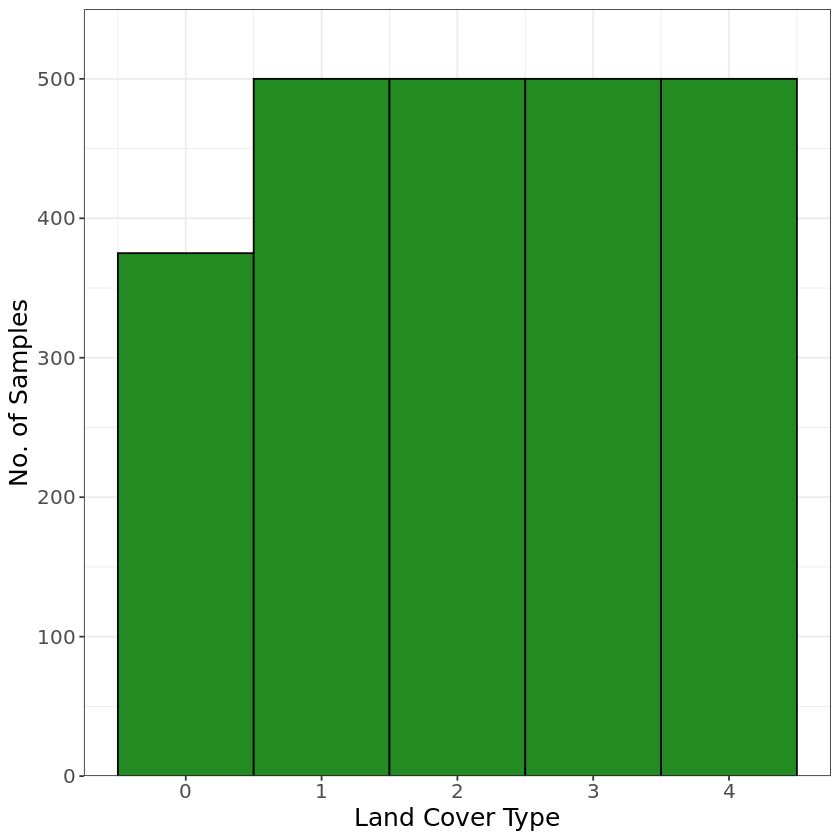

In [4]:
# Show the histogram of different land cover types using ggplot2
AVLData %>% ggplot() + geom_histogram(aes(Class), binwidth = 1, color="black", fill="forestgreen") +
  labs(x="Land Cover Type", y="No. of Samples") + coord_cartesian(ylim=c(0,550), xlim=c(-0.75,4.75), expand=F) +
  theme_bw() + theme(text=element_text(size=15))

As you can see, the data is overall well balanced across different land cover types except for forest (*Class == 0*). 

### 1.2 - Simpilying to a binary example  

Here, we still focus on the binary classification problem for **forest** (*Class == 0*) and **water** (*Class == 4*).  

In [5]:
# We use filter function from dplyr to screen the data
binData <- AVLData %>% filter(Class == 0 | Class == 4); str(binData);
## To facilitate the classifier development, we convert the data type of Class from integer to factor in R
binData$Class <- factor(binData$Class, levels = c(0,4), labels = c("Forest", "Water"))

## spliting the data based on the outcome -- land cover type; 80% for modeling, 20% for testing.
set.seed(6302)
trainIndex <- createDataPartition(binData$Class, p=0.8, list=FALSE, times = 1)
trainData <- binData[trainIndex,]; testData <- binData[-trainIndex,]

tibble [875 × 10] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ X1       : num [1:875] 1 2 3 4 5 6 7 8 9 10 ...
 $ Latitude : num [1:875] 35.5 35.8 35.7 35.5 35.5 ...
 $ Longitude: num [1:875] -82.7 -82.5 -82.3 -82.4 -82.9 ...
 $ Class    : num [1:875] 0 0 0 0 0 0 0 0 0 0 ...
 $ B1       : num [1:875] 127 81 156 245 148 202 208 60 122 207 ...
 $ B2       : num [1:875] 150 115 220 280 181 289 250 91 155 260 ...
 $ B3       : num [1:875] 550 426 538 663 534 651 521 486 463 603 ...
 $ B4       : num [1:875] 226 170 477 507 265 522 408 184 219 441 ...
 $ B5       : num [1:875] 3609 2913 2492 2732 3320 ...
 $ B6       : num [1:875] 1441 1110 2077 1531 1457 ...
 - attr(*, "spec")=
  .. cols(
  ..   X1 = col_double(),
  ..   Latitude = col_double(),
  ..   Longitude = col_double(),
  ..   Class = col_double(),
  ..   B1 = col_double(),
  ..   B2 = col_double(),
  ..   B3 = col_double(),
  ..   B4 = col_double(),
  ..   B5 = col_double(),
  ..   B6 = col_double()
  .. )


Warning message:
“The `i` argument of ``[`()` can't be a matrix as of tibble 3.0.0.
Convert to a vector.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


As we can see, there are only **875** samples for our binary case.  

### 1.3 - Examine the range of features  

Here, we want to check the range of various features (i.e., spectral refelctances) for both classes to see if any feature show notably different data range.  

In [6]:
## using summary() function to examine the range of all sixe OLI channels
binData %>% select(Class, B1:B6) %>% summary()

    Class           B1               B2               B3        
 Forest:375   Min.   :-272.0   Min.   : -36.0   Min.   : 135.0  
 Water :500   1st Qu.: 135.0   1st Qu.: 174.5   1st Qu.: 430.0  
              Median : 195.0   Median : 246.0   Median : 495.0  
              Mean   : 219.6   Mean   : 274.8   Mean   : 508.9  
              3rd Qu.: 289.0   3rd Qu.: 353.5   3rd Qu.: 575.0  
              Max.   :1397.0   Max.   :1484.0   Max.   :1713.0  
       B4               B5               B6        
 Min.   :  56.0   Min.   : -48.0   Min.   :  46.0  
 1st Qu.: 250.0   1st Qu.: 396.5   1st Qu.: 268.0  
 Median : 343.0   Median :1513.0   Median : 791.0  
 Mean   : 391.4   Mean   :1644.5   Mean   : 855.9  
 3rd Qu.: 493.5   3rd Qu.:2825.5   3rd Qu.:1353.5  
 Max.   :1743.0   Max.   :4206.0   Max.   :3303.0  

From this summary table, we can clearly see that **B5** and **B6** show wider data range comparing to the other four bands. In this particular case, this data range difference may not have big impacts on our final classification results. But if there are large magnitude differences amongst your model inputs, it can lead to problematic model outcomes. The input with largest magnitude sometimes can dictates the final model performance if there are no measures to address this issue.  

For example, let's assume one of our model input is surface air temperature in the unit of Kelvin (K) and the other input is surface specific humidity in the unit of kilogram per kilogram (kg/kg). The typical range of temperature over land could be between 210 K ~ 340 K while the specific humidty varies in the order of one thousandth kg/kg. The seven order of magnitude differences could mean that specific humidity has no impact in the final model if used as it is. That's why we need to perform data standardization.  

## 2 - Data Standardization  

### 2.1 - Using *preProcess()* function

Typically, we standardize the data using the mean value and standard deviation from the data set. In **caret** package, this can be simply implemented using the 
function *preProcess()*. This function can also be used to perform other data transformations, such as, principle component analysis (PCA), indepedent component 
analysis (ICA), etc.  

In [7]:
## first, we can check the function preProcess
? preProcess

## According to the documentation, we can specify "center" and "scale" in method to perform the standardization
## Using preProcess function to standardize the data but ignoring Latitude and Longitude
prePrco <- trainData %>% select(-X1, -Latitude, -Longitude) %>% preProcess(., method = c("center", "scale"))

## Now, let's see the result of this standardization
prePrco
print("Mean values of six OLI channels:  ")
print(prePrco$mean)
print("Standard deviation of six OLI channels:  ")
print(prePrco$std)

## One unique thing about preProcess function is that it only creates a "model" for data preprocessing.
## It will only be executed once you apply this model to your data. So, it can be easily implemented to
## both current data for model development and future independent data for model evaluation.

train_Standardized <- predict(prePrco, newdata=trainData)
test_Standardized <- predict(prePrco, newdata=testData)

## Let's check the first 10 rows of the transformed data set
head(train_Standardized, 10)

Created from 700 samples and 7 variables

Pre-processing:
  - centered (6)
  - ignored (1)
  - scaled (6)


[1] "Mean values of six OLI channels:  "
       B1        B2        B3        B4        B5        B6 
 220.6900  275.6743  507.0286  390.4957 1629.1857  844.8543 
[1] "Standard deviation of six OLI channels:  "
       B1        B2        B3        B4        B5        B6 
 122.1509  134.5035  146.8205  195.2057 1216.2371  597.7224 


X1,Latitude,Longitude,Class,B1,B2,B3,B4,B5,B6
<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,35.51477,-82.68045,Forest,-0.7670022,-0.93435711,0.29268001,-0.84267881,1.6278194,0.9973622
2,35.75398,-82.52043,Forest,-1.1435856,-1.19457342,-0.55188864,-1.12955566,1.0555625,0.4435934
3,35.71063,-82.30566,Forest,-0.5295909,-0.41392449,0.21094756,0.44314424,0.7094129,2.0614012
4,35.51281,-82.41386,Forest,0.1990161,0.03216061,1.06232724,0.59682827,0.9067428,1.1479337
5,35.52064,-82.85318,Forest,-0.5950837,-0.70387981,0.18370341,-0.64288957,1.3902012,1.0241304
6,35.61906,-82.80788,Forest,-0.1530075,0.09907338,0.98059479,0.67367028,1.1657384,2.3525063
7,35.55420,-82.50479,Forest,-0.1038879,-0.19088194,0.09515992,0.08967097,1.0489848,1.4942483
8,35.56040,-82.30077,Forest,-1.3155041,-1.37300746,-0.14322639,-1.05783645,1.4814663,0.8317334
10,35.64937,-82.47969,Forest,-0.1120745,-0.11653442,0.65366500,0.25872340,1.2956473,1.5996484


As we can see, the *preProcess()* function not only performed standardization for six OLI channels it also preserved the mean and standard deviation used for the process.

This is very important so this set of parameters can be applied for future testing data sets. 

### 2.2 - Visualize transformed feature space  

Now, let's put the original features and transformed features together.  

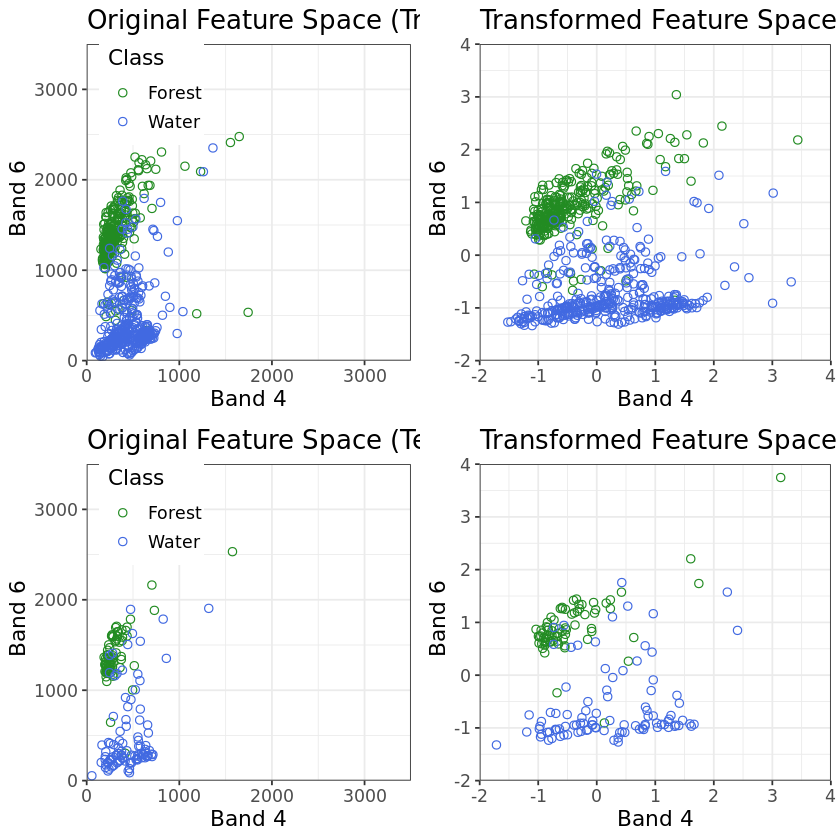

In [8]:
### This is our script to visualize the original feature space for training data (80%)
p1 <- trainData %>% ggplot(aes(x=B4,y=B6)) + geom_point(aes(color=Class), pch=21, size=2) + theme_bw() +
  coord_cartesian(xlim=c(0, 3500), ylim=c(0, 3500), expand=F) + 
  scale_color_manual(values = c("forestgreen", "royalblue")) + labs(x = "Band 4", y = " Band 6") +
  labs(title = "Original Feature Space (Training)") + theme(text=element_text(size=13), legend.position = c(0.2,0.85))

### This is our script to visualize the transformed feature space for training data (80%)
p2 <- train_Standardized %>% ggplot(aes(x=B4,y=B6)) + geom_point(aes(color=Class), pch=21, size=2) + theme_bw() +
  coord_cartesian(xlim=c(-2, 4), ylim=c(-2, 4), expand=F) + 
  scale_color_manual(values = c("forestgreen", "royalblue")) + labs(x = "Band 4", y = " Band 6") +
  labs(title = "Transformed Feature Space (Training)") + theme(text=element_text(size=13), legend.position = "none")

### This is our script to visualize the original feature space for testing data (20%)
p3 <- testData %>% ggplot(aes(x=B4,y=B6)) + geom_point(aes(color=Class), pch=21, size=2) + theme_bw() +
  coord_cartesian(xlim=c(0, 3500), ylim=c(0, 3500), expand=F) + 
  scale_color_manual(values = c("forestgreen", "royalblue")) + labs(x = "Band 4", y = " Band 6") +
  labs(title = "Original Feature Space (Testing)") + theme(text=element_text(size=13), legend.position = c(0.2,0.85))

### This is our script to visualize the transformed feature space for testing data (20%)
p4 <- test_Standardized %>% ggplot(aes(x=B4,y=B6)) + geom_point(aes(color=Class), pch=21, size=2) + theme_bw() +
  coord_cartesian(xlim=c(-2, 4), ylim=c(-2, 4), expand=F) + 
  scale_color_manual(values = c("forestgreen", "royalblue")) + labs(x = "Band 4", y = " Band 6") +
  labs(title = "Transformed Feature Space (Testing)") + theme(text=element_text(size=13), legend.position = "none")

### Putting all four figures together
cowplot::plot_grid(p1,p2,p3,p4, nrow=2, ncol=2)

We can see the difference on the relative frequency in our dataset, which is something that we want to avoid when we are handling our dataset. In extreme cases, the imbalance sample could lead to unreliable model training and/or testing results.

## 3 - Logistic regression  

In this section, we are building the logistic regression model for our binary classification problem. In logistic regression, we can choose different forms of regularlization
to avoid overfitting issue. In **caret** package, there are different variations of logistic regression. We will be using the classic one with the model tag of *"regLogistic"*.

### 3.1 - Get model information  

In [9]:
## check the specifics of the model regularlized logistic regression. 
## Since there are many different variations, we want to match the model tag exactly by turning off the regular expression match.
getModelInfo(model="regLogistic",regex=FALSE)

parameter,class,label
<chr>,<chr>,<chr>
cost,numeric,Cost
loss,character,Loss Function
epsilon,numeric,Tolerance


This model information tells us that there are three hyperparameters can be adjusted for a regularlized logistic regression.  
  1. __"lost"__ controls the form of regularization function. We can choose from _"L1"_, _"L2_dual"_, and _"L2_primal"_;  
  2. __"epsilon"__ determines the tolerence (maximum level) of error for model convergence;  
  3. __"cost"__ modulates the cost of violating the constraints for the data. It Rules the trade-off between regularization and correct classification.    


### 3.2 - Train the model via cross validation  

In this section, let us begin training the regularized logistic regression model for our forest/water classification case by tuning two
hyperparameters - _"loss"_ and _"epsilon"_.   

In [12]:
## trainControl function in R sepecifies whether and how to train your model
LogControl <- trainControl(method = "cv", number=10, classProbs = TRUE) 

## here we specify the parameter grid that we want to search for the optimum model
## we have three different regularization functions, 10 different epsilon values

parGrid <- expand.grid(loss = c("L1", "L2_primal", "L2_dual"), cost = 1,
                       epsilon = c(0.001,0.002,0.005,0.01,0.02,0.04,0.06,0.08,0.1))

set.seed(1024)
## We are now training our model using the standardized data
LogClassifier <- train(Class ~ B1 + B2 + B3 + B4 + B5 + B6, data = trainData, 
                       tuneGrid = parGrid, method = "regLogistic", 
                       trControl = LogControl, preProcess = c("center", "scale"))

LogClassifier

Regularized Logistic Regression 

700 samples
  6 predictor
  2 classes: 'Forest', 'Water' 

Pre-processing: centered (6), scaled (6) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 630, 630, 630, 630, 630, 630, ... 
Resampling results across tuning parameters:

  loss       epsilon  Accuracy   Kappa    
  L1         0.001    0.9500000  0.8981890
  L1         0.002    0.9500000  0.8981890
  L1         0.005    0.9514286  0.9011419
  L1         0.010    0.9500000  0.8981635
  L1         0.020    0.9471429  0.8921344
  L1         0.040    0.9442857  0.8866195
  L1         0.060    0.9442857  0.8866154
  L1         0.080    0.9442857  0.8866144
  L1         0.100    0.9428571  0.8840194
  L2_primal  0.001    0.9514286  0.9010176
  L2_primal  0.002    0.9500000  0.8981376
  L2_primal  0.005    0.9500000  0.8981376
  L2_primal  0.010    0.9500000  0.8981376
  L2_primal  0.020    0.9471429  0.8922325
  L2_primal  0.040    0.9471429  0.8922325
  L2_primal  0.060    0.9414286 

Now, let's try to visualize the cross validation results by creating a level plot (heatmap) of classification accuracies versus the combinatin of both model hyperparameters.
This plot could help us decide which set of model parameters yield the optimum logistic regression model for our binary class classification.


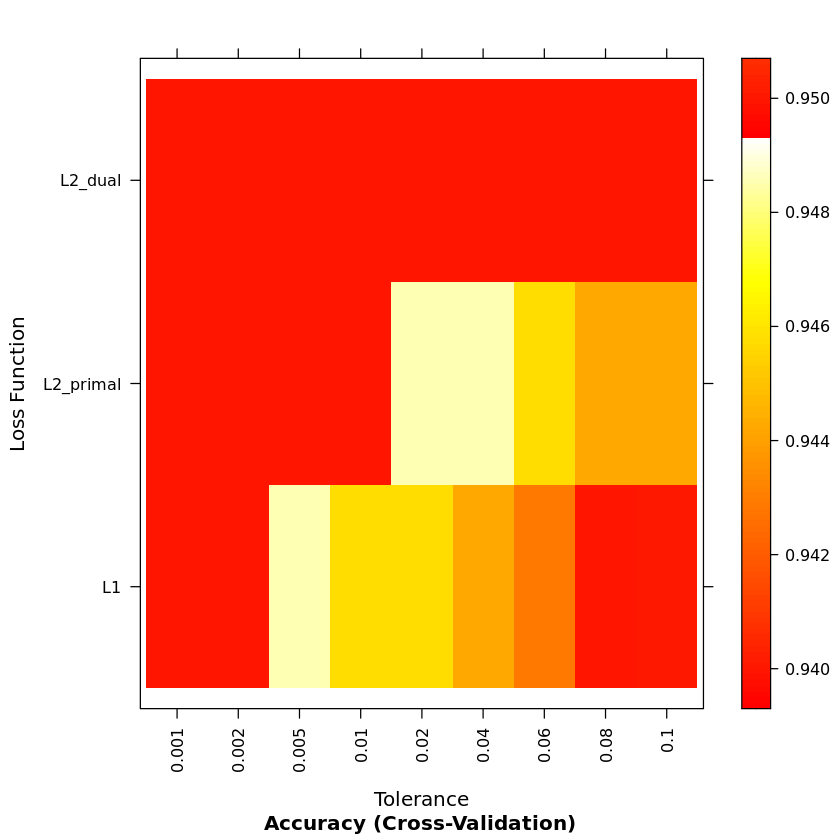

In [11]:
trellis.par.set(caretTheme())
plot(LogClassifier, metric = "Accuracy", plotType = "level", cuts=100,
     pretty=TRUE,
     scales = list(x = list(rot = 90)), col.regions = heat.colors(100))

Based on this 10-fold cross validation, it looks like the L1 regularization yileds the best performance when espilon is small (i.e., 0.001).

Now, let's check how this model performs by looking at the confusion matrix.  

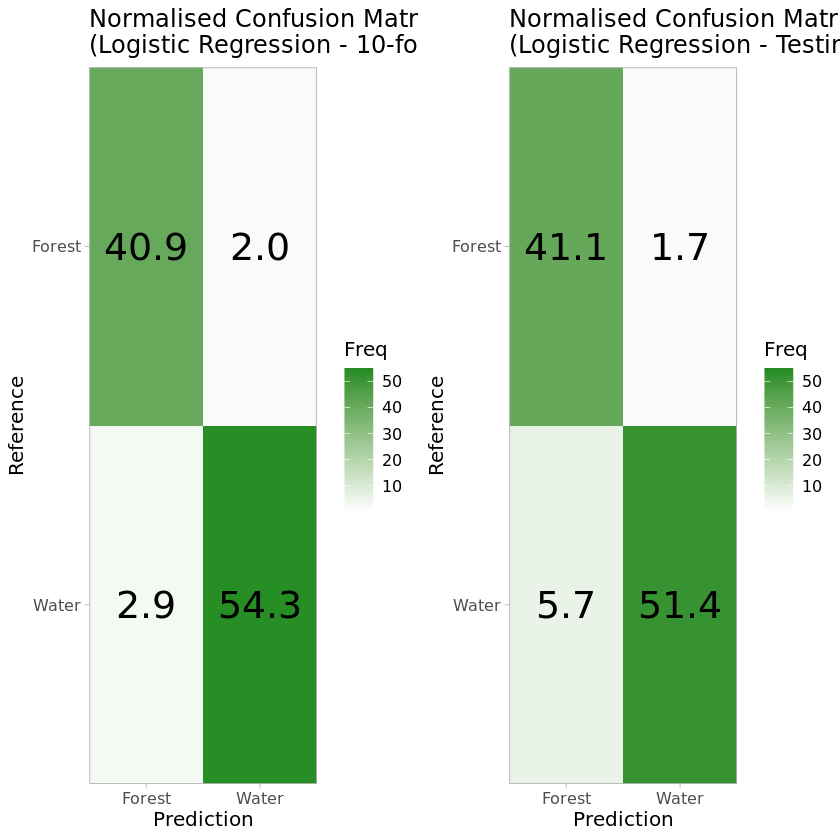

In [14]:
## This line of code calculates the confusion matrix for the cross validation results
LogCV_Matrix <- confusionMatrix(LogClassifier)

## The output of confusionMatrix() is a list containing both the matrix and other quantitative indicators
## Let's just keep the normalised matrix for future comparison since all other indicators can be calculated
## from the matrix
LogCV_Matrix_normalised <- as.data.frame(LogCV_Matrix$table)

## apply the model to test data before calculating the confusion matrix for the testing data
LogPredicted <- predict(LogClassifier, newdata = testData)

## Create confusion matrix for the testing data
LogTest_Matrix <- confusionMatrix(LogPredicted, testData$Class)
LogTest_Matrix_normalised <- as.data.frame(LogTest_Matrix$table/sum(LogTest_Matrix$table))

## put the two confusion matrices side-by-side for comparison
log_p1 <- ggplot(data = LogCV_Matrix_normalised, aes(x = Prediction , y =  Reference, fill = Freq))+
        geom_tile() + scale_fill_gradient(limits=c(0,55), low = "white", high = "forestgreen",
                                          labels=as.character(seq(10,50,10)), breaks=seq(10,50,10)) +
        scale_y_discrete(limits = unique(rev(LogCV_Matrix_normalised$Reference))) +
        geom_text(aes(label = sprintf("%.1f",Freq)), color = 'Black', size = 8) +
        theme_light() + coord_cartesian(expand=F) + theme(text=element_text(size=12))+
        labs(title="Normalised Confusion Matrix \n(Logistic Regression - 10-fold CV)")
log_p2 <- ggplot(data = LogTest_Matrix_normalised, aes(x = Prediction , y =  Reference, fill = Freq))+geom_tile() + 
        scale_fill_gradient(limits=c(0,0.55),low = "white", high = "forestgreen", 
                            labels=as.character(seq(10,50,10)), breaks=seq(0.1,0.5,0.1)) +
        scale_y_discrete(limits = unique(rev(LogTest_Matrix_normalised$Reference))) +
        geom_text(aes(label = sprintf("%.1f",Freq*100)), color = 'Black', size = 8) +
        theme_light() + coord_cartesian(expand=F) + theme(text=element_text(size=12))+
        labs(title="Normalised Confusion Matrix \n(Logistic Regression - Testing)")

cowplot::plot_grid(log_p1, log_p2, nrow=1, ncol=2)

## 4 - Comparing with k-nearest neighbors  

Now we have built two models to address the same question -- a binary class classification for distinguish forest and water using 
Landsat-8 OLI data. Let's put the results from both models together to see if there is any difference in the model performance.  

### 4.1 - Review of our k-NN model  

From our previous tutorial, we have decided that **k=7** yields the best classification result for forest/water classification based on
10-fold cross-validation. Now, let's rebuild this k-NN model anc creates the confusion matrix again. 

In [15]:
## building the model using k=7
knnControl <- trainControl(method="none", classProbs = TRUE)
knnClassifier <- train(Class ~ B1 + B2 + B3 + B4 + B5 + B6, data = trainData, method = "knn", 
                       trControl = knnControl, tuneGrid = data.frame(k=7))

## create confusion matrix for training
knnPredicted <- predict(knnClassifier, newdata = trainData)
knnTrain_Matrix <- confusionMatrix(knnPredicted, trainData$Class)
knnTrain_Matrix_normalised <- as.data.frame(knnTrain_Matrix$table/sum(knnTrain_Matrix$table))

## This is the confusion matrix for k-NN (training)
knnTrain_Matrix

## Create confusion matrix for testing 
knnPredicted <- predict(knnClassifier, newdata = testData)
knnTest_Matrix <- confusionMatrix(knnPredicted, testData$Class)
knnTest_Matrix_normalised <- as.data.frame(knnTest_Matrix$table/sum(knnTest_Matrix$table))

## This is the confusion matrix for k-NN (testing)
knnTest_Matrix

Confusion Matrix and Statistics

          Reference
Prediction Forest Water
    Forest    290    17
    Water      10   383
                                          
               Accuracy : 0.9614          
                 95% CI : (0.9444, 0.9744)
    No Information Rate : 0.5714          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9215          
                                          
 Mcnemar's Test P-Value : 0.2482          
                                          
            Sensitivity : 0.9667          
            Specificity : 0.9575          
         Pos Pred Value : 0.9446          
         Neg Pred Value : 0.9746          
             Prevalence : 0.4286          
         Detection Rate : 0.4143          
   Detection Prevalence : 0.4386          
      Balanced Accuracy : 0.9621          
                                          
       'Positive' Class : Forest          
               

Confusion Matrix and Statistics

          Reference
Prediction Forest Water
    Forest     72     9
    Water       3    91
                                          
               Accuracy : 0.9314          
                 95% CI : (0.8833, 0.9641)
    No Information Rate : 0.5714          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.8614          
                                          
 Mcnemar's Test P-Value : 0.1489          
                                          
            Sensitivity : 0.9600          
            Specificity : 0.9100          
         Pos Pred Value : 0.8889          
         Neg Pred Value : 0.9681          
             Prevalence : 0.4286          
         Detection Rate : 0.4114          
   Detection Prevalence : 0.4629          
      Balanced Accuracy : 0.9350          
                                          
       'Positive' Class : Forest          
               

### 4.2 - Comparing between k-NN and logistic regression  

Now let's put everything together between k-NN and logistc regression.  

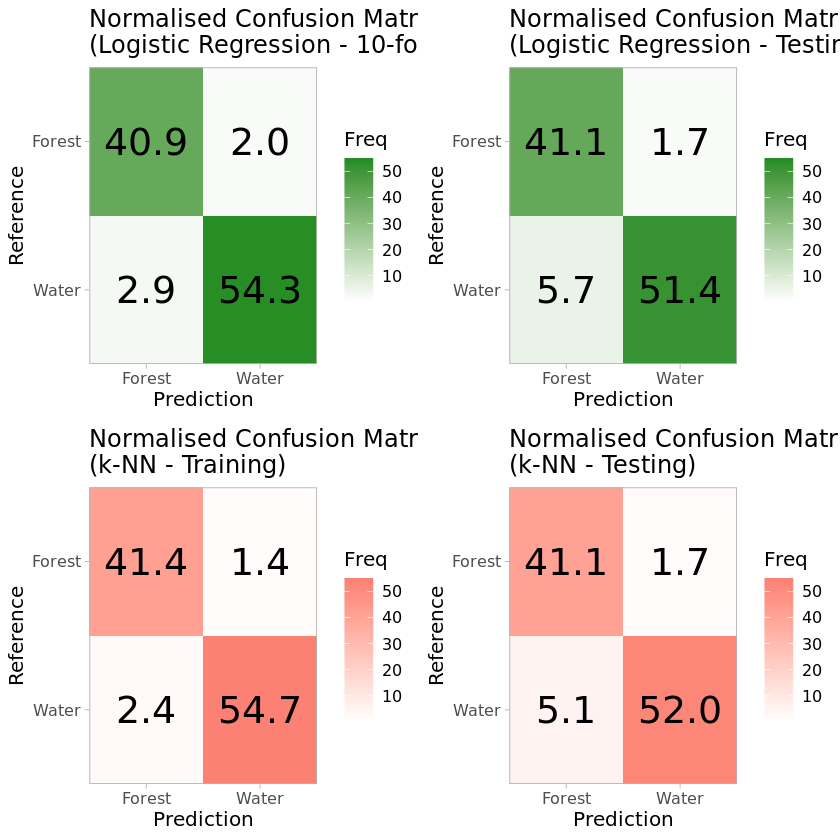

In [16]:
## using ggplot to create heatmap for knn outcomes
## put the two confusion matrices side-by-side for comparison
knn_p1 <- ggplot(data = knnTrain_Matrix_normalised, aes(x = Prediction , y =  Reference, fill = Freq))+
        geom_tile() + scale_fill_gradient(limits=c(0,0.55),low = "white", high = "salmon", 
                            labels=as.character(seq(10,50,10)), breaks=seq(0.1,0.5,0.1)) +
        scale_y_discrete(limits = unique(rev(knnTrain_Matrix_normalised$Reference))) +
        geom_text(aes(label = sprintf("%.1f",Freq*100)), color = 'Black', size = 8) +
        theme_light() + coord_cartesian(expand=F) + theme(text=element_text(size=12))+
        labs(title="Normalised Confusion Matrix \n(k-NN - Training)")
knn_p2 <- ggplot(data = knnTest_Matrix_normalised, aes(x = Prediction , y =  Reference, fill = Freq))+geom_tile() + 
        scale_fill_gradient(limits=c(0,0.55),low = "white", high = "salmon", 
                            labels=as.character(seq(10,50,10)), breaks=seq(0.1,0.5,0.1)) +
        scale_y_discrete(limits = unique(rev(knnTest_Matrix_normalised$Reference))) +
        geom_text(aes(label = sprintf("%.1f",Freq*100)), color = 'Black', size = 8) +
        theme_light() + coord_cartesian(expand=F) + theme(text=element_text(size=12))+
        labs(title="Normalised Confusion Matrix \n(k-NN - Testing)")
  
cowplot::plot_grid(log_p1, log_p2, knn_p1, knn_p2, nrow=2, ncol=2)

From this comparison, it looks like both k-NN and logistic regression model shows same performances on our
independent testing data. Considering the two classes that we are identifying (i.e., forest and water) are easy 
to separate because their unique spectral features (see the scatte plot before), most of the models can do a decent 
job for this task. But will this still be the case if we move on to more complicated tasks, such as, multi-class 
classification? We will move on to these in our next training session.